<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/6_Both_models_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import ast
import joblib

In [49]:
raap = pd.read_csv("RAAP.csv")

In [50]:
for col in raap.columns:
  print(col)

מספר תיק
מספר החלטות בתיק
שם הליך
שנת פתיחת ההליך
מספר הליך
סוג הליך
פירוט סוג הליך
תיק חסוי
תאריך אירוע אחרון
משך התיק בימים
תאריך הגשה
מתוקן סוג הליך
תאריך יצוא התיק
תאריך יצוא הקובץ
תאריך נרמול הקובץ
שם הקובץ
קישור לתיק
שם גורם שיפוטי
תואר גורם שיפוטי
מספר גורמים שיפוטיים במותב
ID
שם השופט
שם השופט מנורמל
שם משפחה מנורמל
שם פרטי מנורמל
מגדר
לאום
דת
קבוצה דתית
שיוך עדתי
ארץ/איזור לידה
שנת לידה
יישוב מגורים מרכזי בילדות
דירוג חברתי כלכלי של  יישוב מגורים מרכזי בילדות
בית ספר תיכון
סוג החינוך
מוסד חינוך משפטי עיקרי
שנת סיום התואר הראשון במשפטים
סוג השכלה משפטית מתקדמת
מוסד חינוך משפטי מתקדם
שנת קבלת התואר המתקדם
מקום התמחות
שנת הסמכה כעורך/ת דין
המשרה האחרונה טרם המינוי לשיפוט
משרה שיפוטית 1
שם בית המשפט במשרה שיפוטית 1
שנת מינוי למשרה שיפוטית 1
משרה שיפוטית 2
שם בית המשפט במשרה שיפוטית 2
שנת מינוי למשרה שיפוטית 2
משרה שיפוטית 3
שם בית המשפט במשרה שיפוטית 3
שנת מינוי למשרה שיפוטית 3
משרה שיפוטית 4
שם בית המשפט במשרה שיפוטית 4
שנת מינוי למשפרה שיפוטית 4
משרה שיפוטית 5
שם בית המשפט במשרה

In [51]:
raap["ניתנה החלטה כמבוקש הבקשה"].unique()

array([nan, "['אין מידע']", "['אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', '28/10/2012', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', '08/08/2013', 'אין מידע']",
       "['אין מידע', 'אין מידע', 'אין מידע', 'אין מידע', '03/09/2018']",
       "['אין מידע', 'אין מידע', '10

נקודה חשובה לציון - בשנים 2000-2001 יש הבדל מהותי בין שם ההליך ומתוכו סוג ההליך, לבין סוג ההליך שנרשם בגוף המסמך עצמו.

In [52]:
raap

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
0,5144/18,1,"רע""פ 5144/18",2018,"רע""פ 5144/18","רע""פ",רשות ערעור פלילי,0.0,2018-07-19,14,...,"['שופט', 'שופט']","['מחוזי ', 'עניינים מקומיים']","['תל אביב', 'בת ים']",NaN,NaN,NaN,NaN,NaN,NaN,2018
1,1746/18,3,"רע""פ 1746/18 אלחננ יהודה פלהיימר נ. מדינת ישראל",2018,"רע""פ 1746/18","רע""פ",רשות ערעור פלילי,0.0,2018-04-29,57,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'פתח-תקווה']",NaN,NaN,NaN,NaN,NaN,NaN,2018
2,4262/18,4,"רע""פ 4262/18 רעננ בנ-טובימ נ. מדינת ישראל- עיר...",2018,"רע""פ 4262/18","רע""פ",רשות ערעור פלילי,0.0,2018-08-08,68,...,['שופט'],['מחוזי '],['תל אביב'],NaN,NaN,NaN,NaN,NaN,NaN,2018
3,1654/18,3,"רע""פ 1654/18 לאה מזרחי נ. מדינת ישראל",2018,"רע""פ 1654/18","רע""פ",רשות ערעור פלילי,0.0,2018-07-29,149,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2018
4,5548/18,4,"רע""פ 5548/18",2018,"רע""פ 5548/18","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,7505/21,1,"רע""פ 7505/21 טל גויחמו נ. מדינת ישראל",2021,"רע""פ 7505/21","רע""פ",רשות ערעור פלילי,0.0,2021-11-11,4,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['פתח תקווה', 'מרכז-לוד']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7874,513/21,3,"רע""פ 513/21 עידנ יהושע נ. מדינת ישראל",2021,"רע""פ 513/21","רע""פ",רשות ערעור פלילי,0.0,2021-03-22,56,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['באר שבע', 'אשקלון']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7875,225/21,1,"רע""פ 225/21 אלקאר דביר בע""מ נ. מדינת ישראל",2021,"רע""פ 225/21","רע""פ",רשות ערעור פלילי,0.0,2021-02-11,30,...,"['שופט', 'שופט']","['מחוזי ', 'עניינים מקומיים']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7876,4075/21,1,"רע""פ 4075/21 דב הרמנ נ. מדינת ישראל",2021,"רע""פ 4075/21","רע""פ",רשות ערעור פלילי,0.0,2021-06-10,0,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2021


# Clean Doc's body - נקיון גוף המסמך

In [53]:
print((df_full_ra_rap["גוף המסמך"].iloc[2]))

['החלטה בתיק רע"פ 4262/18 בבית המשפט העליון רע"פ 4262/18 לפני: כבוד השופט (בדימ\') א\' שהם המבקש: רענן בן-טובים נגד המשיבה: מדינת ישראל- עיריית תל אביב המבקשת להצטרף: "נח" – התאחדות ישראלית של ארגונים להגנת בעלי חיים בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי תל אביב-יפו, מיום 30.4.2018, בעפ"א 52614-02-18, שניתן על ידי כב\' השופטת מ\' סוקולוב – שופטת עמיתה; בקשה להצטרף להליך כידיד בית המשפט המבקש: בעצמו בשם המשיבה: עו"ד איתמר גלבפיש בשם המבקשת להצטרף: עו"ד ענבל קידר-חיים החלטה 1. לפניי בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בתל אביב-יפו (כב\' השופטת מ\' סוקולוב – שופטת עמיתה), בעפ"א 52614-02-18, מיום 30.4.2018. בגדרו של פסק הדין, התקבל ערעורה של המשיבה על הכרעת דינו של בית המשפט לעניינים מקומיים בתל אביב-יפו (כב\' השופט ע\' מסארווה), בתיק 08140284157, מיום 8.1.2018. רקע והליכים קודמים 2. לחובת המבקש נרשם דו"ח בגין החזקת כלב שאינו קשור ברצועה או בשרשרת במקום ציבורי, לפי סעיף 11(א) לחוק עזר לתל אביב-יפו (פיקוח על כלבים ובעלי חיים אחרים) התשס"א-2000 (להלן: חוק העזר), אשר במס

In [54]:
# פונקציה להמרת טקסט שמופיע כרשימה למחרוזת רגילה
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            # מנסה להמיר את התוכן בתוך הסוגריים לרשימה אמיתית
            text_list = ast.literal_eval(text)
            # איחוד המחרוזות לרצף טקסט אחד
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

# פונקציה לניקוי התווים המיותרים
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)  # הפיכת רשימה למחרוזת
    elif isinstance(text, str):
        # הסרת תווי רווח מיותרים ותווים מיוחדים
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים
        return text.strip()
    return text

# הדפסת שורות לא קריאות לפני המרה
print("שורות לא קריאות לפני המרה:")
print(raap["גוף המסמך"].head())

# המרה של הטקסטים הלא קריאים לטקסטים קריאים ושמירה על הדאטה המקורי
raap["גוף המסמך"] = raap["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(raap["גוף המסמך"].head())

# file_path = 'full_final_df_cleaned.csv'
# df_full_ra_rap.to_csv(file_path, index=False, encoding='utf-8')

# print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


שורות לא קריאות לפני המרה:
0    ['החלטה בתיק רע"פ 5144/18 בבית המשפט העליון רע...
1    ['החלטה בתיק רע"פ 1746/18 בבית המשפט העליון רע...
2    ['החלטה בתיק רע"פ 4262/18 בבית המשפט העליון רע...
3    ['החלטה בתיק רע"פ 1654/18 בבית המשפט העליון רע...
4    ['החלטה בתיק רע"פ 5548/18 בבית המשפט העליון רע...
Name: גוף המסמך, dtype: object

שורות לאחר המרה:
0    ['החלטה בתיק רע"פ 5144/18 בבית המשפט העליון רע...
1    ['החלטה בתיק רע"פ 1746/18 בבית המשפט העליון רע...
2    ['החלטה בתיק רע"פ 4262/18 בבית המשפט העליון רע...
3    ['החלטה בתיק רע"פ 1654/18 בבית המשפט העליון רע...
4    ['החלטה בתיק רע"פ 5548/18 בבית המשפט העליון רע...
Name: גוף המסמך, dtype: object


# DCA Files only

In [55]:
years =[2021,2016,2011,2004,2003,2006,2008,2002,2022]

In [56]:
sample_df = raap[raap["שנת פתיחת ההליך"].isin(years)]
sample_df

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
297,7081/22,1,"רע""פ 7081/22",2022,"רע""פ 7081/22","רע""פ",רשות ערעור פלילי,0.0,2022-11-06,11,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'רמלה']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2022
298,4789/22,1,"רע""פ 4789/22",2022,"רע""פ 4789/22","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
299,6979/22,2,"רע""פ 6979/22 אולג דודקה נ. מדינת ישראל",2022,"רע""פ 6979/22","רע""פ",רשות ערעור פלילי,0.0,2022-11-03,8,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'פתח-תקווה']",NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע', 'אין מידע']",2022
300,8576/22,1,"רע""פ 8576/22",2022,"רע""פ 8576/22","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
301,3355/22,1,"רע""פ 3355/22 עלאא סלאמה נ. מדינת ישראל",2022,"רע""פ 3355/22","רע""פ",רשות ערעור פלילי,0.0,2022-05-26,8,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['חיפה', 'חדרה']",NaN,NaN,NaN,NaN,NaN,NaN,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,7505/21,1,"רע""פ 7505/21 טל גויחמו נ. מדינת ישראל",2021,"רע""פ 7505/21","רע""פ",רשות ערעור פלילי,0.0,2021-11-11,4,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['פתח תקווה', 'מרכז-לוד']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7874,513/21,3,"רע""פ 513/21 עידנ יהושע נ. מדינת ישראל",2021,"רע""פ 513/21","רע""פ",רשות ערעור פלילי,0.0,2021-03-22,56,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['באר שבע', 'אשקלון']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7875,225/21,1,"רע""פ 225/21 אלקאר דביר בע""מ נ. מדינת ישראל",2021,"רע""פ 225/21","רע""פ",רשות ערעור פלילי,0.0,2021-02-11,30,...,"['שופט', 'שופט']","['מחוזי ', 'עניינים מקומיים']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7876,4075/21,1,"רע""פ 4075/21 דב הרמנ נ. מדינת ישראל",2021,"רע""פ 4075/21","רע""פ",רשות ערעור פלילי,0.0,2021-06-10,0,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2021


In [57]:
sample_df["שנת פתיחת ההליך"].unique()

array([2022, 2002, 2003, 2004, 2008, 2006, 2011, 2016, 2021])

In [58]:
sample_df = sample_df[sample_df["סוג הליך"]=='רע"פ']
# בדיקה אם בעמודת "גוף המסמך" קיימת המילה "רע"פ"
contains_raap = sample_df["גוף המסמך"].str.contains('רע"פ', na=False)

# ספירה של כמה מסמכים מכילים את המילה רע"פ וכמה לא
count_yes = contains_raap.sum()
count_no = len(contains_raap) - count_yes

# הדפסת הספירה
print(f"מספר המסמכים שמכילים את המילה 'רע\"פ': {count_yes}")
print(f"מספר המסמכים שלא מכילים את המילה 'רע\"פ': {count_no}")

# סינון הדאטה לשמירת רק המסמכים שכן מכילות את המילה
sample_df = sample_df[contains_raap]

# שמירה לקובץ חדש אם יש צורך
output_file = "filtered_sample_with_raap.csv"
sample_df.to_csv(output_file, index=False, encoding="utf-8")
print(f"הדאטה המסונן נשמר לקובץ: '{output_file}'")


מספר המסמכים שמכילים את המילה 'רע"פ': 3073
מספר המסמכים שלא מכילים את המילה 'רע"פ': 0
הדאטה המסונן נשמר לקובץ: 'filtered_sample_with_raap.csv'


In [59]:
sample_df = sample_df[
    (sample_df["סוג הליך"] == 'רע"פ') &
    (sample_df["מספר הליך"].str.contains('רע"פ', na=False))
]
sample_df

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
297,7081/22,1,"רע""פ 7081/22",2022,"רע""פ 7081/22","רע""פ",רשות ערעור פלילי,0.0,2022-11-06,11,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'רמלה']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2022
298,4789/22,1,"רע""פ 4789/22",2022,"רע""פ 4789/22","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
299,6979/22,2,"רע""פ 6979/22 אולג דודקה נ. מדינת ישראל",2022,"רע""פ 6979/22","רע""פ",רשות ערעור פלילי,0.0,2022-11-03,8,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'פתח-תקווה']",NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע', 'אין מידע']",2022
300,8576/22,1,"רע""פ 8576/22",2022,"רע""פ 8576/22","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
301,3355/22,1,"רע""פ 3355/22 עלאא סלאמה נ. מדינת ישראל",2022,"רע""פ 3355/22","רע""פ",רשות ערעור פלילי,0.0,2022-05-26,8,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['חיפה', 'חדרה']",NaN,NaN,NaN,NaN,NaN,NaN,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,7505/21,1,"רע""פ 7505/21 טל גויחמו נ. מדינת ישראל",2021,"רע""פ 7505/21","רע""פ",רשות ערעור פלילי,0.0,2021-11-11,4,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['פתח תקווה', 'מרכז-לוד']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7874,513/21,3,"רע""פ 513/21 עידנ יהושע נ. מדינת ישראל",2021,"רע""פ 513/21","רע""פ",רשות ערעור פלילי,0.0,2021-03-22,56,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['באר שבע', 'אשקלון']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7875,225/21,1,"רע""פ 225/21 אלקאר דביר בע""מ נ. מדינת ישראל",2021,"רע""פ 225/21","רע""פ",רשות ערעור פלילי,0.0,2021-02-11,30,...,"['שופט', 'שופט']","['מחוזי ', 'עניינים מקומיים']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7876,4075/21,1,"רע""פ 4075/21 דב הרמנ נ. מדינת ישראל",2021,"רע""פ 4075/21","רע""פ",רשות ערעור פלילי,0.0,2021-06-10,0,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2021


In [60]:
sample_df.shape[0]

3073

# Drop null

In [61]:
sample_df[["גוף המסמך"]].dropna(how='any', ignore_index=True,inplace=True)
sample_df[["מספר הליך","שם הליך"]].dropna(how='all', ignore_index=True,inplace=True)
sample_df[["מספר הליך","שם הליך"]].drop_duplicates(inplace=True, ignore_index=True)
sample_df

<ipython-input-61-9f43abb7fdde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["גוף המסמך"]].dropna(how='any', ignore_index=True,inplace=True)
<ipython-input-61-9f43abb7fdde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["מספר הליך","שם הליך"]].dropna(how='all', ignore_index=True,inplace=True)
<ipython-input-61-9f43abb7fdde>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[["מספר הליך","שם הליך"]].d

,מספר תיק,מספר החלטות בתיק,שם הליך,שנת פתיחת ההליך,מספר הליך,סוג הליך,פירוט סוג הליך,תיק חסוי,תאריך אירוע אחרון,משך התיק בימים,...,סוג גורם שיפוטי דלמטה,סוג בית משפט דלמטה,מקום בית משפט דלמטה,הליך מאוחד,שמות ההליכים המאוחדים,צדדים נוספים,מספר תיק מלא,מספר השופטים,ניתנה החלטה כמבוקש הבקשה,Year
297,7081/22,1,"רע""פ 7081/22",2022,"רע""פ 7081/22","רע""פ",רשות ערעור פלילי,0.0,2022-11-06,11,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'רמלה']",NaN,NaN,NaN,NaN,NaN,['אין מידע'],2022
298,4789/22,1,"רע""פ 4789/22",2022,"רע""פ 4789/22","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
299,6979/22,2,"רע""פ 6979/22 אולג דודקה נ. מדינת ישראל",2022,"רע""פ 6979/22","רע""פ",רשות ערעור פלילי,0.0,2022-11-03,8,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['מרכז-לוד', 'פתח-תקווה']",NaN,NaN,NaN,NaN,NaN,"['אין מידע', 'אין מידע', 'אין מידע']",2022
300,8576/22,1,"רע""פ 8576/22",2022,"רע""פ 8576/22","רע""פ",רשות ערעור פלילי,1.0,1900-01-01,-2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
301,3355/22,1,"רע""פ 3355/22 עלאא סלאמה נ. מדינת ישראל",2022,"רע""פ 3355/22","רע""פ",רשות ערעור פלילי,0.0,2022-05-26,8,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['חיפה', 'חדרה']",NaN,NaN,NaN,NaN,NaN,NaN,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,7505/21,1,"רע""פ 7505/21 טל גויחמו נ. מדינת ישראל",2021,"רע""פ 7505/21","רע""פ",רשות ערעור פלילי,0.0,2021-11-11,4,...,"['שופט', 'שופט']","['תעבורה', 'מחוזי ']","['פתח תקווה', 'מרכז-לוד']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7874,513/21,3,"רע""פ 513/21 עידנ יהושע נ. מדינת ישראל",2021,"רע""פ 513/21","רע""פ",רשות ערעור פלילי,0.0,2021-03-22,56,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['באר שבע', 'אשקלון']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7875,225/21,1,"רע""פ 225/21 אלקאר דביר בע""מ נ. מדינת ישראל",2021,"רע""פ 225/21","רע""פ",רשות ערעור פלילי,0.0,2021-02-11,30,...,"['שופט', 'שופט']","['מחוזי ', 'עניינים מקומיים']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2021
7876,4075/21,1,"רע""פ 4075/21 דב הרמנ נ. מדינת ישראל",2021,"רע""פ 4075/21","רע""פ",רשות ערעור פלילי,0.0,2021-06-10,0,...,"['הרכב', 'שופט']","['מחוזי ', 'שלום']","['תל אביב', 'תל אביב']",NaN,NaN,NaN,NaN,NaN,NaN,2021


In [62]:
cut_sample_df = sample_df[["גוף המסמך","מספר הליך","שם הליך","שנת פתיחת ההליך"]].reset_index()
cut_sample_df

,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך
0,297,"['החלטה בתיק רע""פ 7081/22 בבית המשפט העליון רע...","רע""פ 7081/22","רע""פ 7081/22",2022
1,298,"['החלטה בתיק רע""פ 4789/22 בבית המשפט העליון רע...","רע""פ 4789/22","רע""פ 4789/22",2022
2,299,"['החלטה בתיק רע""פ 6979/22 בבית המשפט העליון רע...","רע""פ 6979/22","רע""פ 6979/22 אולג דודקה נ. מדינת ישראל",2022
3,300,"['החלטה בתיק רע""פ 8576/22 בבית המשפט העליון רע...","רע""פ 8576/22","רע""פ 8576/22",2022
4,301,"['החלטה בתיק רע""פ 3355/22 בבית המשפט העליון רע...","רע""פ 3355/22","רע""פ 3355/22 עלאא סלאמה נ. מדינת ישראל",2022
...,...,...,...,...,...
3068,7873,"['החלטה בתיק רע""פ 7505/21 בבית המשפט העליון רע...","רע""פ 7505/21","רע""פ 7505/21 טל גויחמו נ. מדינת ישראל",2021
3069,7874,"['החלטה בתיק רע""פ 513/21 בבית המשפט העליון רע""...","רע""פ 513/21","רע""פ 513/21 עידנ יהושע נ. מדינת ישראל",2021
3070,7875,"['החלטה בתיק רע""פ 225/21 בבית המשפט העליון רע""...","רע""פ 225/21","רע""פ 225/21 אלקאר דביר בע""מ נ. מדינת ישראל",2021
3071,7876,"['החלטה בתיק רע""פ 4075/21 בבית המשפט העליון רע...","רע""פ 4075/21","רע""פ 4075/21 דב הרמנ נ. מדינת ישראל",2021


In [63]:
cut_sample_df.to_csv("cut_sample_df.csv", index=False, encoding='utf-8')

# Cut missing ending files

## FIX THIS!!!


In [64]:
# הגדרת פונקציה לעיצוב טקסט
def format_text(text, line_length=80):
    """
    פורמט טקסט כך שיהיה נוח לקריאה עם שורות שאורכן מוגבל.
    """
    import textwrap
    return "\n".join(textwrap.wrap(text, width=line_length))


In [65]:
# ביטויים לבדיקה
keywords = ["העותק כפוף לשינויי עריכה וניסוח", "העתק מתאים", 'ניתנההיום', 'ניתןהיום', 'ניתן היום', 'ניתנה היום',
            "העתקמתאים", "מזכיר ראשי", "supreme.court.gov.il", "מרכז מידע", "מרכזמידע"]

# בדיקה אילו שורות מכילות אחד מהביטויים
rows_with_keyword = cut_sample_df["גוף המסמך"].apply(
    lambda x: any(keyword in x for keyword in keywords) if isinstance(x, str) else False
)

# סינון שורות שלא מכילות את הביטוי
filtered_data = cut_sample_df[rows_with_keyword]

# הדפסת מספר השורות שנמחקו
num_removed = len(cut_sample_df) - len(filtered_data)  # **שונה לחישוב מדויק**
print(f"\nמספר השורות שנמחקו: {num_removed}")

# **שינוי לצורך סעיף 6**: בדיקה אם נותרו ערכים חסרים בעמודת "גוף המסמך"
missing_values_count = filtered_data["גוף המסמך"].isna().sum()
if missing_values_count > 0:
    print(f"\nנותרו {missing_values_count} ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.")
else:
    print("\nאין ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.")


# עדכון הטבלה המקורית
cut_sample_df = filtered_data.copy()



מספר השורות שנמחקו: 27

אין ערכים חסרים בעמודת 'גוף המסמך' לאחר סינון.

הנתונים המסוננים נשמרו לקובץ: 'new_filtered_data.csv'


In [ ]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = data["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = data[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = data[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
text = (rows_without_keyword["גוף המסמך"].to_string(index=False))
formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
print(formatted_text)
print("##*******************************************************####")

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

data = filtered_data

In [85]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text,min_length=500,last_sen=30):


    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text



In [ ]:
# הסרת שורות עם ערכים חסרים בעמודת "גוף המסמך"
cut_sample_df = cut_sample_df.dropna(subset=["גוף המסמך"]).copy()

# חיתוך הטקסטים בעמודת "גוף המסמך"
cut_sample_df["גוף המסמך חתוך"] = cut_sample_df["גוף המסמך"].apply(trim_text)

# שמירת האינדקס המקורי
cut_sample_df.reset_index(inplace=True, drop=False)  # שונה להבטחת שמירת אינדקס מקורי


In [67]:
cut_sample_df.head()


,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך
0,0,297,"['החלטה בתיק רע""פ 7081/22 בבית המשפט העליון רע...","רע""פ 7081/22","רע""פ 7081/22",2022,"בית משפט קמא מיצה עמו את הדין. אכן, לא מדרכה ש..."
1,1,298,"['החלטה בתיק רע""פ 4789/22 בבית המשפט העליון רע...","רע""פ 4789/22","רע""פ 4789/22",2022,"מתחשב בנסיבות ביצוע העבירה ונסיבותיו האישיות,..."
2,2,299,"['החלטה בתיק רע""פ 6979/22 בבית המשפט העליון רע...","רע""פ 6979/22","רע""פ 6979/22 אולג דודקה נ. מדינת ישראל",2022,"""ד יעקב שקלאר החלטה בנסיבות האמורות, אני נעתר ..."
3,3,300,"['החלטה בתיק רע""פ 8576/22 בבית המשפט העליון רע...","רע""פ 8576/22","רע""פ 8576/22",2022,ר כי אין מקום למצות עמו את הדין כערכאת ערעור (...
4,4,301,"['החלטה בתיק רע""פ 3355/22 בבית המשפט העליון רע...","רע""פ 3355/22","רע""פ 3355/22 עלאא סלאמה נ. מדינת ישראל",2022,"ודוק, לא מצאתי בעונשו של המבקש משום חריגה קיצ..."


# Embedding

In [68]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import joblib
import pandas as pd

# טעינת המודל והטוקנייזר
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

# בדיקה אם עמודת "גוף המסמך חתוך" קיימת ומכילה ערכים תקינים
if "גוף המסמך חתוך" not in cut_sample_df.columns or cut_sample_df["גוף המסמך חתוך"].isna().all():
    raise ValueError("עמודת 'גוף המסמך חתוך' חסרה או ריקה. יש לוודא חיתוך טקסטים תקין לפני המשך.")

# חישוב האימבדינגים עבור כל שורה בעמודת "גוף המסמך חתוך"
print("מתחילים לחשב אימבדינגים על גוף המסמך החתוך...")
embeddings_new = np.array([get_embeddings(text) for text in cut_sample_df["גוף המסמך חתוך"]])
print("אימבדינגים חושבו בהצלחה!")


מתחילים לחשב אימבדינגים על גוף המסמך החתוך...
אימבדינגים חושבו בהצלחה!



# Model prediction

In [69]:
# טוען את המודל
classifier = joblib.load("2_classifier_model_double_trained.pkl")
print("המודל נטען בהצלחה.")

# חיזוי הסתברויות
print("מתחילים לחזות הסתברויות...")
predicted_probabilities = classifier.predict_proba(embeddings_new)[:, 1]
print("הסתברויות נחזו בהצלחה!")

# הוספת עמודת ההסתברויות
cut_sample_df["predicted_probability"] = predicted_probabilities



# יצירת תחזיות לפי המודל המקורי (ללא שימוש בטרשהולד מותאם)
cut_sample_df["prediction_original_model"] = classifier.predict(embeddings_new)

# **תוספת סעיף 4**: בדיקת התפלגות התחזיות
class_distribution = cut_sample_df["prediction_original_model"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי המודל המקורי):")
print(class_distribution)

# בדיקת התפלגות נורמלית
normalized_distribution = cut_sample_df["prediction_original_model"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):")
print(normalized_distribution)


# שמירה של התחזיות והנתונים לקובץ Excel
output_file = "2_full_data_with_predictions.xlsx"
cut_sample_df.to_excel(output_file, index=False, engine="openpyxl")
print(f"הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '{output_file}'")


המודל נטען בהצלחה.
מתחילים לחזות הסתברויות...
הסתברויות נחזו בהצלחה!

כמות Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_original_model
0    2722
1     324
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_original_model
0    0.893631
1    0.106369
Name: proportion, dtype: float64
הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '2_full_data_with_predictions.xlsx'



# Analysis

In [70]:
# ווידוא שקיימת עמודת שנה
if "שנת פתיחת ההליך" not in cut_sample_df.columns:
    raise ValueError("עמודת 'שנת פתיחת ההליך' חסרה בדאטה. יש לוודא שהמידע קיים לפני המשך.")

# בדיקת כמות הערכים לכל שנה
year_counts = cut_sample_df["שנת פתיחת ההליך"].value_counts().sort_index()
print("\nNumber of values for each year:")
print(year_counts)

# יצירת טבלת התפלגות
class_distribution_by_year = cut_sample_df.groupby("שנת פתיחת ההליך")["prediction_original_model"].value_counts(normalize=True).unstack(fill_value=0)

# המרה לאחוזים
class_distribution_by_year = class_distribution_by_year * 100

# הדפסת התפלגות הכיתות לפי שנה
print("\nהתפלגות הכיתות לפי תחזיות המודל (%):")
print(class_distribution_by_year)

# שמירה לקובץ Excel
output_file = "3_no_treshold_class_distribution_by_year.xlsx"
class_distribution_by_year.to_excel(output_file, engine="openpyxl")
print(f"\nהתפלגות הכיתות נשמרה בקובץ: {output_file}")



Number of values for each year:
שנת פתיחת ההליך
2002      4
2003    360
2004    435
2006    476
2008    637
2011    420
2016    306
2021    226
2022    182
Name: count, dtype: int64

התפלגות הכיתות לפי תחזיות המודל (%):
prediction_original_model           0          1
שנת פתיחת ההליך                                 
2002                       100.000000   0.000000
2003                        87.500000  12.500000
2004                        87.816092  12.183908
2006                        89.915966  10.084034
2008                        90.580848   9.419152
2011                        86.428571  13.571429
2016                        89.542484  10.457516
2021                        92.920354   7.079646
2022                        92.857143   7.142857

התפלגות הכיתות נשמרה בקובץ: 3_no_treshold_class_distribution_by_year.xlsx


In [71]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# הגדרת פונט
rcParams['font.family'] = 'DejaVu Sans'  # מתאים כברירת מחדל

def plot_probability_distribution_separate_by_year(df, year_column, probability_column, bins=50):
    """
    Displays a separate histogram for each year of the probability distribution.

    Parameters:
    df: pandas.DataFrame - The data table.
    year_column: str - The column name representing the year.
    probability_column: str - The column name representing the probabilities.
    bins: int - The number of bins in the histogram.
    """
    # Check if the columns exist
    if year_column not in df.columns or probability_column not in df.columns:
        raise ValueError(f"Columns {year_column} or {probability_column} are missing in the DataFrame.")

    # Get unique years
    unique_years = sorted(df[year_column].dropna().unique())

    # Create separate histograms for each year
    for year in unique_years:
        plt.figure(figsize=(10, 6))
        plt.hist(
            df[df[year_column] == year][probability_column],
            bins=bins,
            alpha=0.7,
            color="blue",
            edgecolor="black"
        )

        # Set graph labels and titles
        plt.title(f"Probability Distribution for Year {year}", fontsize=16, loc='center')
        plt.xlabel("Predicted Probability", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.xlim(0, 1)  # Probabilities always between 0 and 1
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


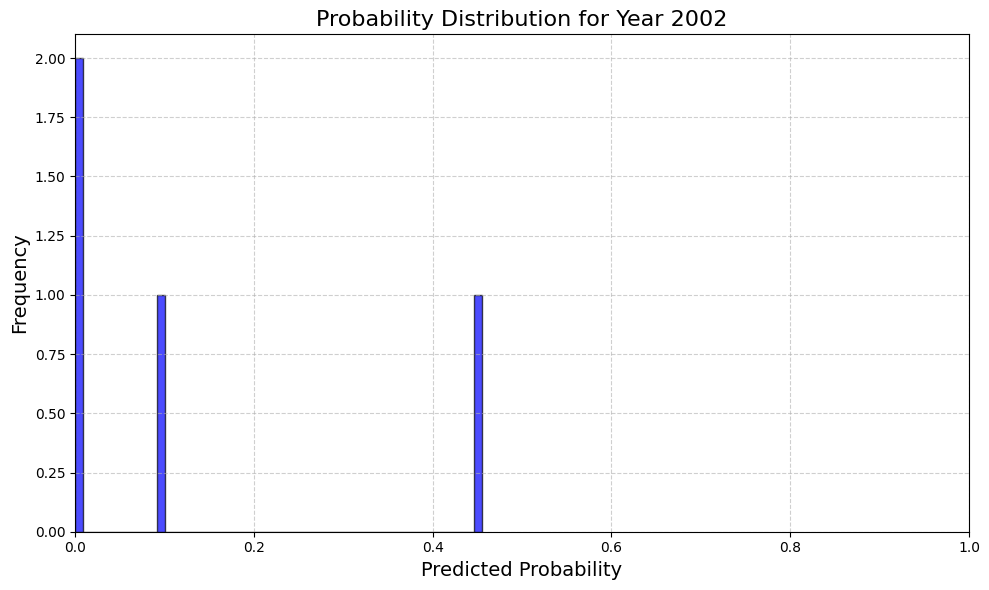

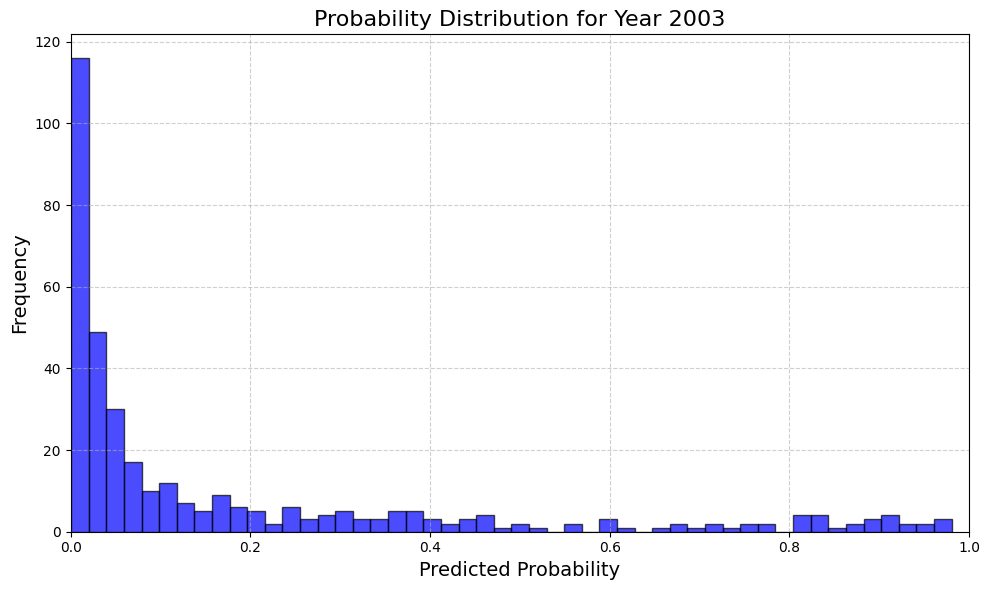

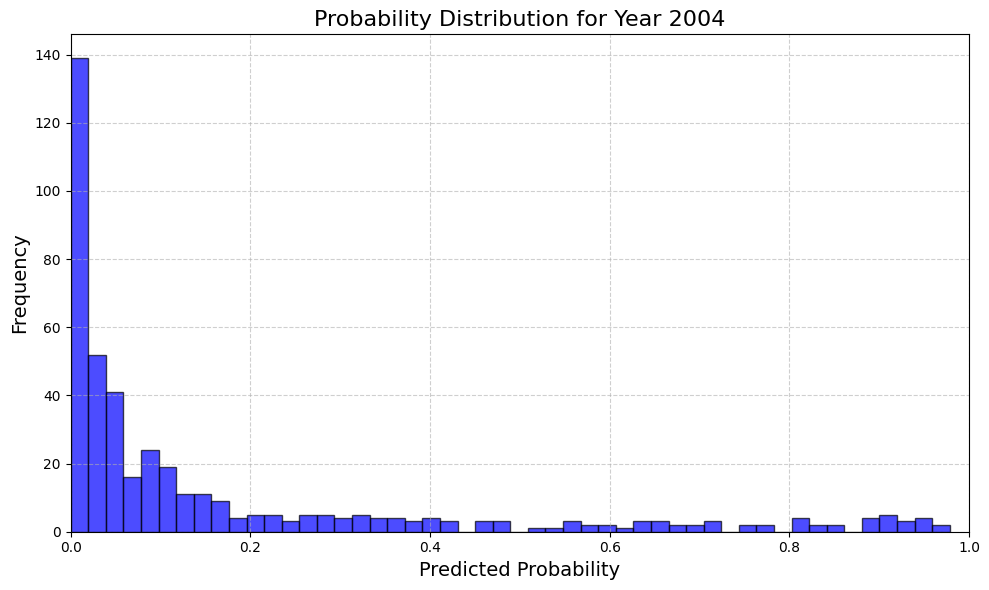

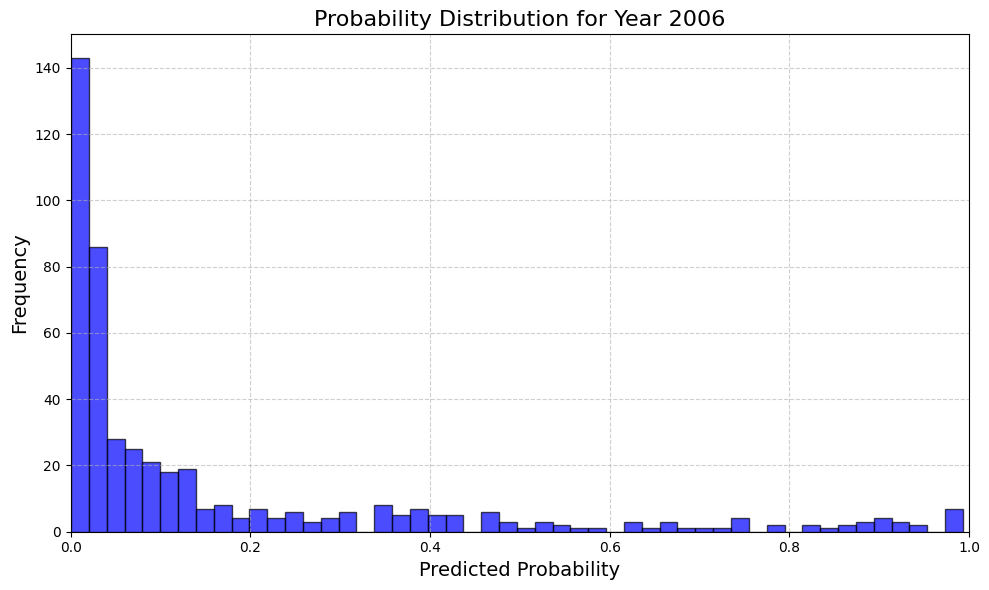

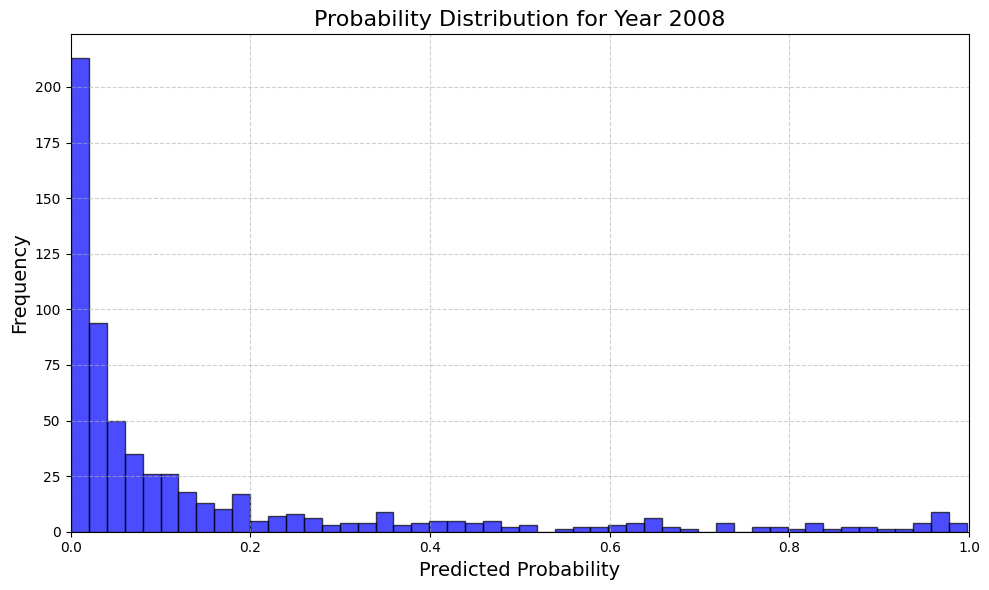

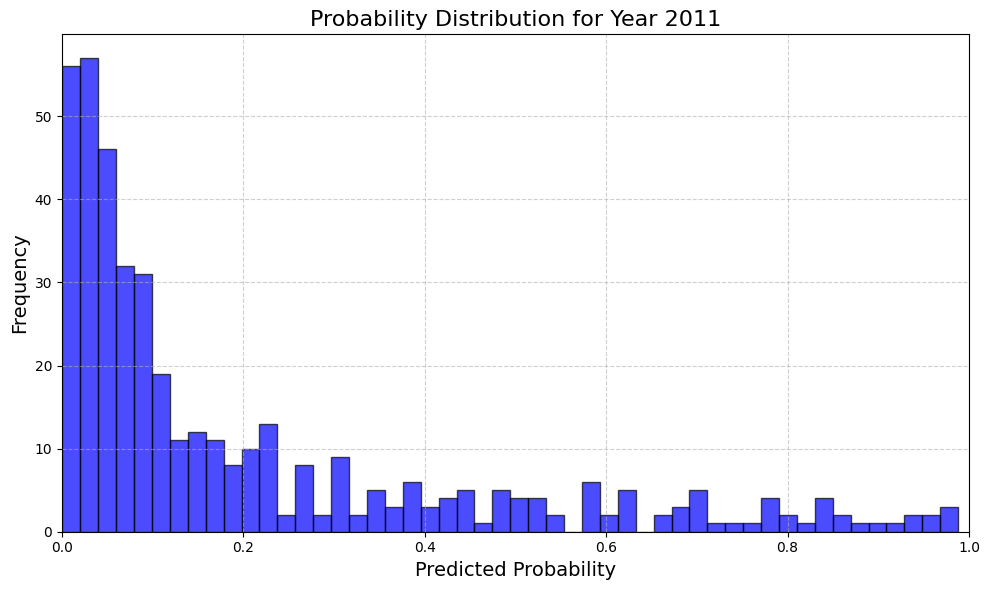

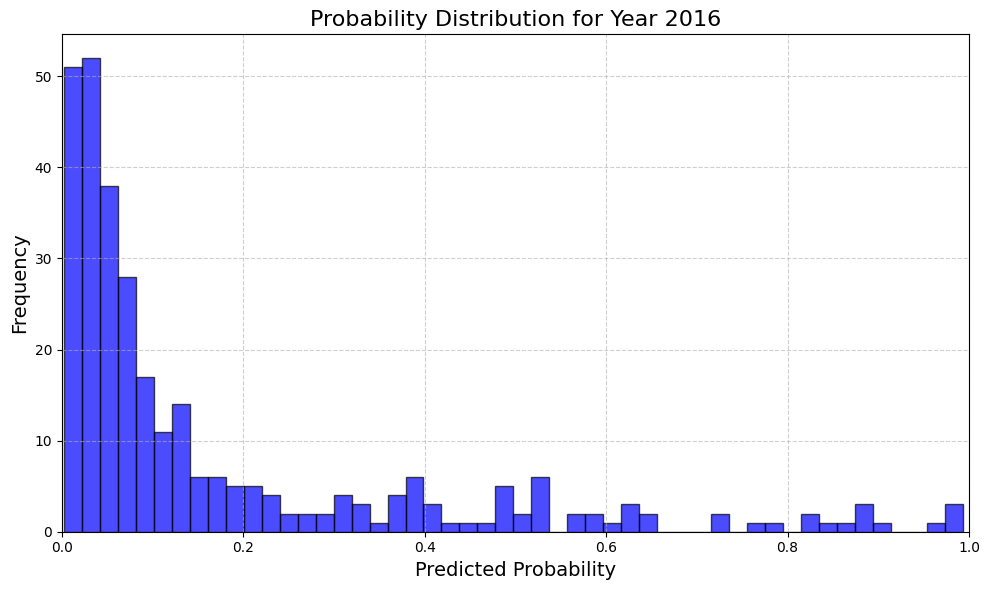

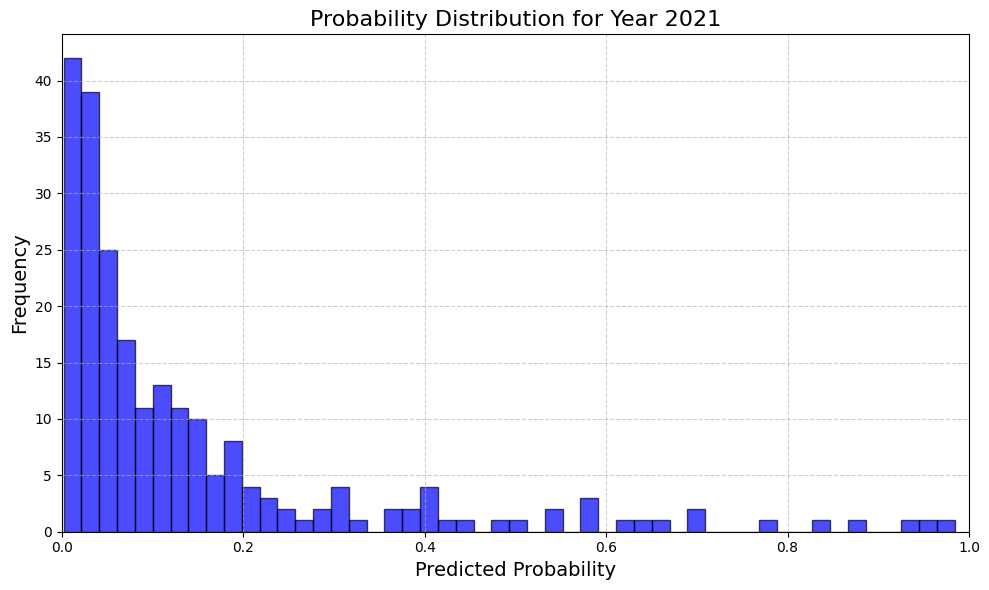

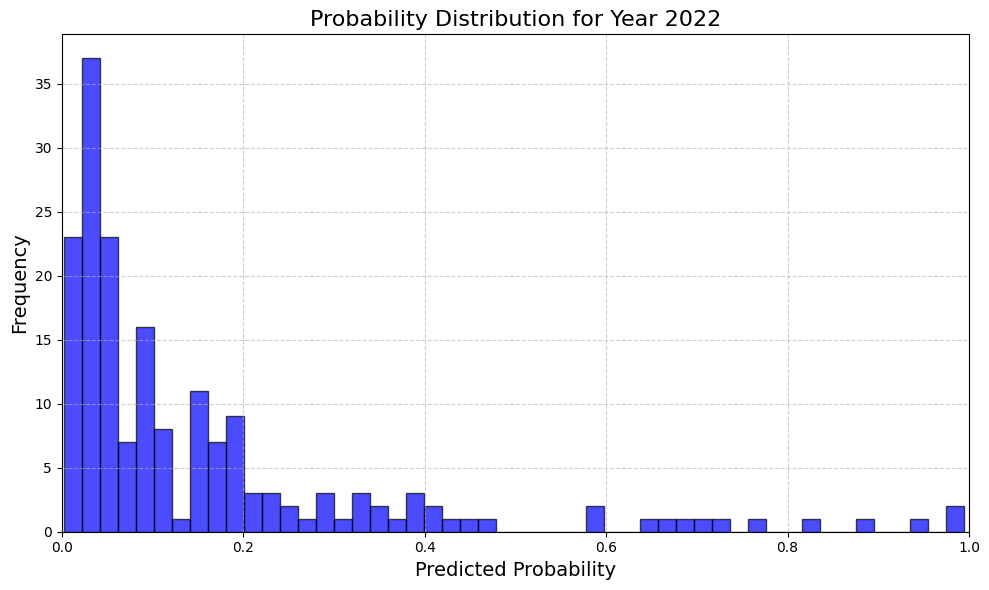

In [72]:
# ווידוא שעומדת "שנת פתיחת ההליך" קיימת
if "שנת פתיחת ההליך" not in cut_sample_df.columns:
    raise ValueError("עמודת 'שנת פתיחת ההליך' חסרה ב-DataFrame.")

# קריאה לפונקציה להצגת גרף נפרד לכל שנה
plot_probability_distribution_separate_by_year(cut_sample_df, "שנת פתיחת ההליך", "predicted_probability")


# Second classifier prediction  

In [76]:
# df = pd.read_excel("2_full_data_with_predictions.xlsx")

In [ ]:
df = cut_sample_df.copy()

In [77]:
df[df["prediction_original_model"]==1].shape[0]

324

In [78]:
df[df["prediction_original_model"]==1]

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model
44,44,341,"['החלטה בתיק רע""פ 2115/22 בבית המשפט העליון רע...","רע""פ 2115/22","רע""פ 2115/22 טל טרווינשיונל נ. מדינת ישראל",2022,"2 בבית המשפט העליון רע""פ 2115/22 - ב\' לפני: כ...",0.684419,1
78,78,375,"['פסק דין בתיק רע""פ 770/22 בבית המשפט העליון ר...","רע""פ 770/22","רע""פ 770/22 אברהמ נהוראי נ. מדינת ישראל",2022,". משהמערער נמצא מתאים לעבודות שירות, אנו מחליט...",0.726758,1
84,84,381,"['פסק דין בתיק רע""פ 1195/22 בבית המשפט העליון ...","רע""פ 1195/22","רע""פ 1195/22 זיאד אשחאדאת נ. מדינת ישראל",2022,כפי שפורט לעיל בהרחבה ואשר לעונשי המאסר בפועל ...,0.994473,1
85,85,382,"['פסק דין בתיק רע""פ 7234/22 בבית המשפט העליון ...","רע""פ 7234/22","רע""פ 7234/22 אליצור אהרונ נ. מדינת ישראל",2022,"עור בזכות או ברשות, ועל כן לא נדרש להכריע באשר...",0.821466,1
101,101,398,"['פסק דין בתיק רע""פ 8732/22 בבית המשפט העליון ...","רע""פ 8732/22","רע""פ 8732/22 גאהד בנ מחמוד שואהינ נ. מדינת ישראל",2022,"ברסלר-גונן ו-ט\' לחיאני-שהם תאריך הישיבה: כ""ט ...",0.887701,1
...,...,...,...,...,...,...,...,...,...
2997,3024,7829,"['פסק דין בתיק רע""פ 2093/21 בבית המשפט העליון ...","רע""פ 2093/21","רע""פ 2093/21 שלומית כהן- 19 אח' נ. ש.י. שפץ וק...",2021,"ם כהלכתם, בערכאה הדיונית, קרי, בבית משפט השלום...",0.928235,1
3001,3028,7833,"['החלטה בתיק רע""פ 7192/21 בבית המשפט העליון רע...","רע""פ 7192/21","רע""פ 7192/21",2021,"['החלטה בתיק רע""פ 7192/21 בבית המשפט העליון רע...",0.706741,1
3014,3041,7846,"['החלטה בתיק רע""פ 3287/21 בבית המשפט העליון רע...","רע""פ 3287/21","רע""פ 3287/21 זארע עתמינ נ. מדינת ישראל",2021,נגד המשיבה: מדינת ישראל בקשה לעיכוב ביצוע עונש...,0.838266,1
3039,3066,7871,"['החלטה בתיק רע""פ 2335/21 בבית המשפט העליון רע...","רע""פ 2335/21","רע""פ 2335/21",2021,המלצת שירות המבחן או את טענתה לפיה עצם קיומו ...,0.614582,1


In [79]:
data = df[df["prediction_original_model"]==1]

In [81]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

In [86]:
data["גוף המסמך חתוך מסווג שני"] = data["גוף המסמך"].apply(lambda x: trim_text(x, 550, 80))

Trimmed Text (Original Length: 1150, Trimmed Length: 550):
דנים בבקשה כבערעור עצמו.בהסכמת המדינה אנו מבטלים את החלטתו של בית משפט השלום, לפ
יה "המאשימה תוכללבצע את צו ההריסה שניתן למבנה בחלוף 3 חודשים מהיום", ואת החלטתו 
של ביתהמשפט המחוזי לפיה "המשיבה תהיה רשאית לבצע את צו ההריסה (אם המערער לא ביצעא
ותו) תוך 3 חודשים מהיום". ביסוד גישתנו זו מונחת התפיסה כי הארכת המועדלביצוע צו ה
הריסה הוא בסמכותו של בית המשפט המקורי, שהוציא את הצו. שאר חלקי גזרהדין יעמדו בעי
נם. ניתן היום, כ"ט בכסלו התשס"ד(24.12.2003), בפני באי כוח הצדדים. ה נ ש י א ש ו 
פט ש ו פ ט _________________________העותק כפוף לשינויי עריכה וניסוח. 0
##*******************************************************####
Trimmed Text (Original Length: 3454, Trimmed Length: 550):
פט המחוזי אכן נפלו פגמים, המחייבים בחינה מחודשת של טענות הצדדיםבאשר לפיצוי ולקנס
 שהוטלו על המבקש. לפיכך, הציעה המשיבה להחזיר את הדיון לביתהמשפט המחוזי והמבקש הו
דיע על הסכמתו להצעתה זו של המשיבה. לאור כל האמור, ובהתאם להסכמת הצדדים, אנו נעתר
יםלבקשה למתן רשות ער

In [88]:
embeddings_new = np.array([get_embeddings(text) for text in data["גוף המסמך חתוך מסווג שני"]])

In [90]:
# טוען את המודל
second_classifier = joblib.load("second_classifier_model.pkl")
print("המודל נטען בהצלחה.")

# חיזוי הסתברויות
print("מתחילים לחזות הסתברויות...")
predicted_probabilities = classifier.predict_proba(embeddings_new)[:, 1]
print("הסתברויות נחזו בהצלחה!")

# הוספת עמודת ההסתברויות
data["second_model_predicted_probability"] = predicted_probabilities



# יצירת תחזיות לפי המודל המקורי (ללא שימוש בטרשהולד מותאם)
data["prediction_second_model"] = classifier.predict(embeddings_new)

# **תוספת סעיף 4**: בדיקת התפלגות התחזיות
class_distribution = data["prediction_second_model"].value_counts()
print("\nכמות Class 0 ו-Class 1 (לפי המודל המקורי):")
print(class_distribution)

# בדיקת התפלגות נורמלית
normalized_distribution = data["prediction_second_model"].value_counts(normalize=True)
print("\nהתפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):")
print(normalized_distribution)




המודל נטען בהצלחה.
מתחילים לחזות הסתברויות...
הסתברויות נחזו בהצלחה!

כמות Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_second_model
1    277
0     10
Name: count, dtype: int64

התפלגות נורמלית של Class 0 ו-Class 1 (לפי המודל המקורי):
prediction_second_model
1    0.965157
0    0.034843
Name: proportion, dtype: float64


In [92]:
data = pd.concat([data,df])

In [93]:
data.drop_duplicates(subset = ["מספר הליך"],keep = 'first', inplace=True)

In [94]:
# שמירה של התחזיות והנתונים לקובץ Excel
output_file = "full_data_both_models_with_predictions.xlsx"
data.to_excel(output_file, index=False, engine="openpyxl")
print(f"הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: '{output_file}'")


הטבלה המלאה עם הפרדיקציות נשמרה בקובץ: 'full_data_both_models_with_predictions.xlsx'
